In [1]:
from ddrnet_23_slim import DualResNet_imagenet, DualResNet
import numpy as np
import keras
import tensorflow as tf
import sys
from Utility import *
from tensorflow.data import AUTOTUNE
from Dataset_helper import *
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from focal_loss import SparseCategoricalFocalLoss

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
image_path = "D:/VUT_FSI/Magister/00_Diplomka/SegNet-Tensorflow/dataset/photo_7678"
mask_path = "D:/okk/mask_1d"

In [5]:
def load_dataset(path, size):
    
    def load_images_from_file(image_path, size):
    
        image = tf.io.read_file(image_path, name='image')
        image = tf.image.decode_jpeg(image, channels=3, dct_method='INTEGER_ACCURATE')
        image = tf.image.resize(image, size=size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR) / 255
        image = tf.cast(image, 'float32')

        return image
    
    def load_mask_from_file(mask_path, size):
    
        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_png(mask, channels=3)
        mask = (tf.image.resize(mask, size=size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR) / 255) * 12
        mask = mask[:,:,0]
        mask = tf.cast(tf.math.round(mask), 'uint8')

        return mask

    image_path = path[0]
    mask_path = path[1]
    
    image = load_images_from_file(image_path, size)
    mask = load_mask_from_file(mask_path, size)
    
#     print(mask_path)
    
    
    return image, mask

In [6]:
def augment_using_layers(images, mask, size=None):
    
    if size is None:
        h_s = mask.shape[0]
        w_s = mask.shape[1]
    else:
        h_s = size[0]
        w_s = size[1]
    
    def aug(height=h_s, width=w_s):

        flip = tf.keras.layers.RandomFlip(mode="horizontal")
        
        rota = tf.keras.layers.RandomRotation(0.2, fill_mode='constant')
        
        zoom = tf.keras.layers.RandomZoom(
                            height_factor=(-0.05, -0.3),
                            fill_mode='wrap',
                            interpolation='nearest'
                            )
        
        trans = tf.keras.layers.RandomTranslation(height_factor=(-0.1, 0.1),
                                            width_factor=(-0.1, 0.1), 
                                            fill_mode='constant')
        
        crop = tf.keras.layers.RandomCrop(h_s, w_s)
        
        layers = [flip, zoom, crop]
        aug_model = tf.keras.Sequential(layers)

        return aug_model
    
    bright = tf.keras.layers.RandomContrast(factor=0.8)
    
    aug = aug()
    
    mask = tf.stack([mask, mask, mask], -1)
    mask = tf.cast(mask, 'float32')

    images_mask = tf.concat([images, mask], -1)  
    images_mask = aug(images_mask)  
    
    image = images_mask[:,:,0:3]
    mask = images_mask[:,:,4]
    
    return bright(image), tf.cast(mask, 'uint8')

In [7]:
img_all = load_data(image_path, 
                    mask_path, 
                    split=True,
                    per_split=[0.6, 0.2, 0.2],
                    seed=4232,
                    format=['.jpg', '.png'])

img_train, mask_train, img_val, mask_val, img_test, mask_test = img_all

--------------------------------------------------
Train data: 3494
Val data: 1164
Test data: 1166
--------------------------------------------------
--------------------------------------------------
Number of same samples between train, val and test dataset 0
--------------------------------------------------
Return order: images_train, masks_train, images_val, masks_val, image_test, mask_test
--------------------------------------------------
Number of samples from input data: 5824
Number of samples after split: 5824
--------------------------------------------------


In [8]:
IMAGE_SIZE = (720, 1280)
MASK_SIZE = IMAGE_SIZE

BS = 15

paired_train = pair_correct(img_train, mask_train, two_in_one=True)
paired_val = pair_correct(img_val, mask_val, two_in_one=True)
paired_test = pair_correct(img_test, mask_test, two_in_one=True)

print("[INFO] creating a tf.data train input pipeline..")
dataset_train = tf.data.Dataset.from_tensor_slices(paired_train)
dataset_train = (dataset_train
                .shuffle(len(paired_train))
                .map(lambda x: load_dataset(x, IMAGE_SIZE), num_parallel_calls=AUTOTUNE)
                .cache()
                .map(lambda x, y: augment_using_layers(x, y, MASK_SIZE),
                        num_parallel_calls=AUTOTUNE)
                .batch(BS)
                .prefetch(AUTOTUNE)
                
)

print("[INFO] creating a tf.data val input pipeline..")
dataset_val = tf.data.Dataset.from_tensor_slices(paired_val)
dataset_val = (dataset_val
                .map(lambda x: load_dataset(x, MASK_SIZE), num_parallel_calls=AUTOTUNE)
                .batch(BS)
                .prefetch(AUTOTUNE)
)

print("[INFO] creating a tf.data test input pipeline..")
dataset_test = tf.data.Dataset.from_tensor_slices(paired_test)
dataset_test = (dataset_test
                .map(lambda x: load_dataset(x, MASK_SIZE), num_parallel_calls=AUTOTUNE)
                .batch(BS)
                .prefetch(AUTOTUNE)
)

[INFO] creating a tf.data train input pipeline..
[INFO] creating a tf.data val input pipeline..
[INFO] creating a tf.data test input pipeline..


In [ ]:
def flatten(t):
    return [item for sublist in t for item in sublist]

for image, mask in dataset_test.take(1):
    sample_image, sample_mask = image, mask
    
display_list = [[sample_image[i], sample_mask[i]] for i in range(0,BS)]
display_list = flatten(display_list)


display_images(display_list[0:10], title=['img', 'mask'], style='2column')

In [9]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
        super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)
    
    def get_config(self):
        config = super().get_config().copy()
        return config

In [10]:
# create model
MODEL_IMG_SIZE = (list((MASK_SIZE)) + [3])
BATCH_SIZE=None
NUM_CLASS = 12


METRICS = [ tf.metrics.SparseCategoricalAccuracy(name='sparseCatAcc'),
            UpdatedMeanIoU(num_classes=12, name='mIoU'),
#             tfa.metrics.F1Score(num_class=12)
          ]

model, pre_model = DualResNet_imagenet(shape=MODEL_IMG_SIZE, 
                                       batch=BATCH_SIZE, 
                                       num_class=NUM_CLASS, 
                                       softmax_act=True)
    
pre_model.trainable = False


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=SparseCategoricalFocalLoss(gamma=5), 
              metrics=METRICS,
             )

In [19]:
lear_schedule = tf.keras.callbacks.LearningRateScheduler(
                lambda epoch: 1e-3 * 10 ** (epoch / 30)
                )

CALLBACKS = [lear_schedule]

In [ ]:
# training
epochs = 1
model_history33 = model_336.fit(dataset_train, 
                          epochs=epochs, 
                          validation_data=dataset_val)

(-0.5, 599.5, 335.5, -0.5)

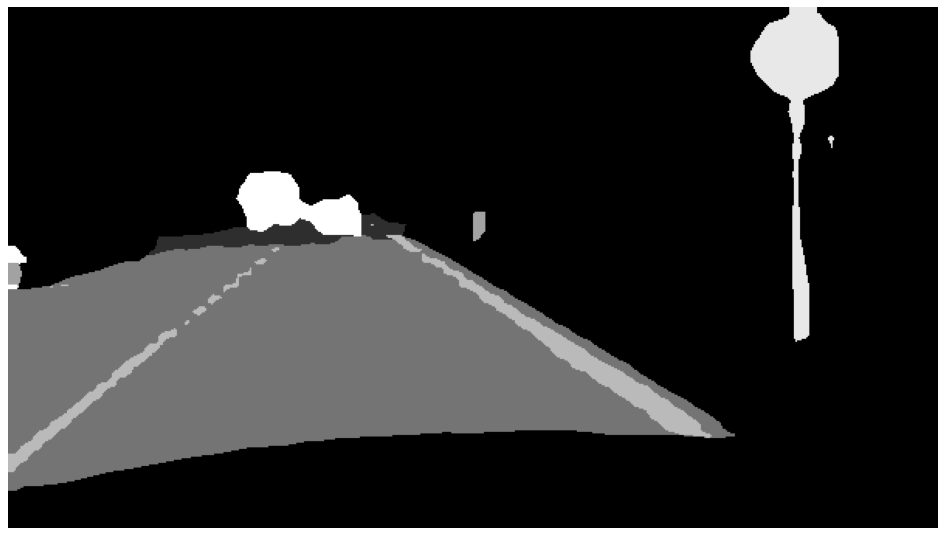

In [42]:
# prediction example
base_path = 'D:/VUT_FSI/Magister/00_Diplomka/SegNet-Tensorflow/dataset/photo_7678//311.jpg'
img = load_img(base_path, target_size=MASK_SIZE, color_mode='rgb')
img = img_to_array(img)

img = np.expand_dims(tf.convert_to_tensor(img)/255, 0)

pred_img1 = model.predict(img)
    
fig = plt.figure(figsize=(15, 15), dpi=80)
plt.imshow(np.argmax(pred_img1[0,:,:,:], axis=-1), cmap='gray')
plt.axis('off')

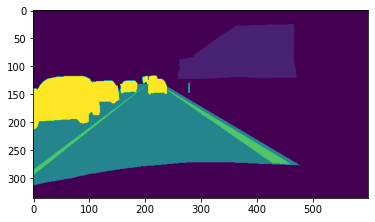

In [108]:
# mask example
base_path = "D://okk/mask_1d//60.png"
mask = load_img(base_path, target_size=MASK_SIZE, color_mode='rgb')
mask2 = img_to_array(mask)[:,:,0]
plt.imshow(mask2)

(-0.5, 599.5, 335.5, -0.5)

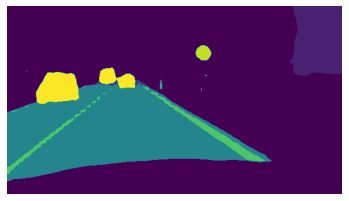

In [93]:
# predicstion example
plt.imshow(np.argmax(out[0,:,:,:], axis=-1))
plt.axis('off')